# Getting data -> (X,y) with all the features

In [52]:
# from raptor_functions.supervised.datasets import get_data
# df = get_data('handheld_data')

In [53]:
from raptor_functions.supervised.datasets import get_data
df = get_data('handheld_data')

In [54]:
df.head()

,exp_unique_id,exp_name,timesteps,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_23,sensor_24,Humidity (r.h.),measurement_stage,date_exp,time_elapsed,datetime_exp_start,datetime_exp,filename,result
0,0,Test 24,1,131.938,132.443,177.444,178.157,44.974,44.508,219.374,...,143.288,142.050,46.07,baseline,21/3/2022,0.00,14:12:54,2022-03-21 14:12:54.000,5 NegTest_3_20220321_14_12.txt,Control
1,0,Test 24,2,133.078,133.972,177.444,178.694,45.131,44.611,219.607,...,142.874,141.914,46.07,baseline,21/3/2022,0.25,14:12:54,2022-03-21 14:12:54.250,5 NegTest_3_20220321_14_12.txt,Control
2,0,Test 24,3,131.812,132.064,177.622,178.694,45.183,44.663,219.841,...,143.288,141.914,46.07,baseline,21/3/2022,0.50,14:12:54,2022-03-21 14:12:54.500,5 NegTest_3_20220321_14_12.txt,Control
3,0,Test 24,4,131.059,132.064,177.444,178.694,45.183,44.663,219.607,...,142.599,141.368,46.07,baseline,21/3/2022,0.75,14:12:54,2022-03-21 14:12:54.750,5 NegTest_3_20220321_14_12.txt,Control
4,0,Test 24,5,131.435,131.938,177.622,178.694,45.131,44.663,219.607,...,142.187,140.825,46.07,baseline,21/3/2022,1.00,14:12:54,2022-03-21 14:12:55.000,5 NegTest_3_20220321_14_12.txt,Control


In [55]:
import numpy as np
import pandas as pd
import xgboost as xgb
from boruta import BorutaPy
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import (
    ComprehensiveFCParameters,
    extract_features,
)
from tsfresh import extract_features

In [56]:
FEATURES = [
    "exp_unique_id",
    "timesteps",
    "sensor_1",
    "sensor_2",
    "sensor_3",
    "sensor_4",
    "sensor_5",
    "sensor_6",
    "sensor_7",
    "sensor_8",
    "sensor_9",
    "sensor_10",
    "sensor_11",
    "sensor_12",
    "sensor_13",
    "sensor_14",
    "sensor_15",
    "sensor_16",
    "sensor_17",
    "sensor_18",
    "sensor_19",
    "sensor_20",
    "sensor_21",
    "sensor_22",
    "sensor_23",
    "sensor_24",
]

TARGET_COL = "result"

unique_id="exp_unique_id"
label="result"
timesteps="timesteps"

In [57]:
extraction_settings = ComprehensiveFCParameters()

In [58]:
y = df.groupby(unique_id).first()[label]
X = df.drop(label, axis=1)

In [59]:
features = [col for col in X if col.startswith('sensor')]
features = [unique_id, timesteps] + features

X = X[features]

# X = df.drop(label, axis=1)
# y = df.groupby(unique_id).first()[label]

X = extract_features(
    X,
    column_id=unique_id,
    column_sort=timesteps,
    default_fc_parameters=extraction_settings,
    # we impute = remove all NaN features automatically
    impute_function=impute,
)

Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


# Function for PCA

Inputs: X, y
Outputs: plot and pandas dataframe with the 2d decomposition

In [60]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [61]:
def PCA_plot(X,y,scaler = True, plt_3D = True, figure_name = 'pca_plot', path = os.getcwd()):
    # 
    if plt_3D == True:
        n_components = 3
    else:
        n_components = 2
    pca = PCA(n_components=n_components)
    if scaler == True:
        pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
        principalComponents = pipe.fit_transform(X)
    else: 
        principalComponents = pca.fit_transform(X)
    # 
    principalDf = pd.DataFrame(data = principalComponents)
    # 
    colors = {'Control':'green', 'Covid':'red'}
    # 
    # 
    if n_components == 2:
        fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
        ax = sns.scatterplot(x=principalDf.iloc[:,0], y=principalDf.iloc[:,1], hue=y, alpha=0.9, edgecolor='black')
    elif n_components == 3:
        # 
        fig = plt.figure(figsize=(6,6))    
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)    
        cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
        sc = ax.scatter(principalDf.iloc[:,0],principalDf.iloc[:,1],principalDf.iloc[:,2], c=y.map(colors), cmap=cmap, alpha=0.9, edgecolors='black')
        ax.set_zlabel('Axis 3')
    else:
        print('Error: please only select 2 or 3 axis for the Principal Component Analysis.')
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title('Principal Component Analysis (PCA)')
    # -----------------------------------------------------------
    # TODO: create new directory if path specified doesn't exists
    figure_name_full = figure_name + '.pdf'
    if path != os.getcwd():
        plt.savefig(path + "/" + figure_name_full, bbox_inches='tight')
        print('Plot saved sucesfully!')
    else: 
        plt.savefig(figure_name_full, bbox_inches='tight')
        print('Plot saved sucesfully!')

Plot saved sucesfully!


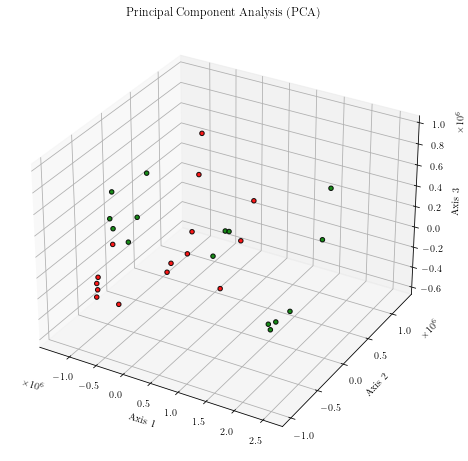

In [62]:
PCA_plot(X,y,scaler=False,plt_3D=True,figure_name = 'pca_plot_test_3d', path = '/Users/danielfiuzadosil/Documents/GitHub/raptor_functions/raptor_functions/dev/plots')

Plot saved sucesfully!


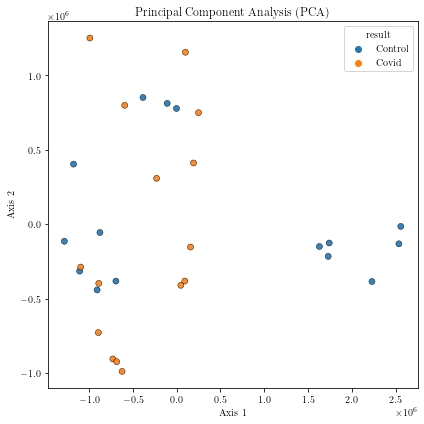

In [63]:
PCA_plot(X,y,scaler=False,plt_3D=False)

# LDA

In [64]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [68]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
# X_r2 = lda.fit(X, y).transform(X)

ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

In [70]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X,y)
principalDf = tsne_results

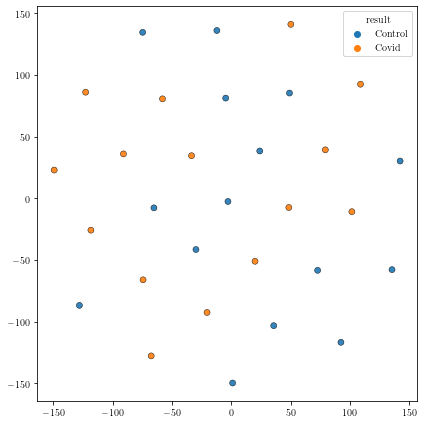

In [69]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
ax = sns.scatterplot(x=principalDf[:,0], y=principalDf[:,1], hue=y, alpha=0.9, edgecolor='black')

In [78]:
from sklearn.decomposition import PCA, KernelPCA
kpca = KernelPCA(n_components=2)
X_kpca = kpca.fit_transform(X)
principalDf = X_kpca

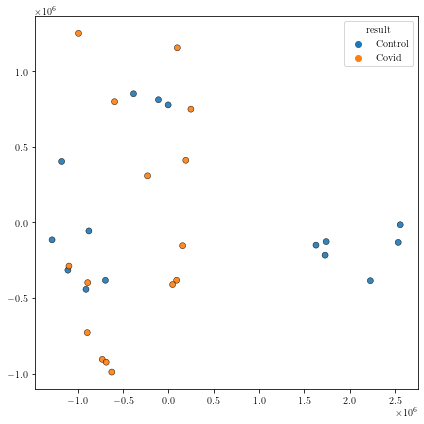

In [79]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
ax = sns.scatterplot(x=principalDf[:,0], y=principalDf[:,1], hue=y, alpha=0.9, edgecolor='black')

In [82]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
X_MDS = embedding.fit_transform(X)
principalDf = X_MDS
# 
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
ax = sns.scatterplot(x=principalDf[:,0], y=principalDf[:,1], hue=y, alpha=0.9, edgecolor='black')

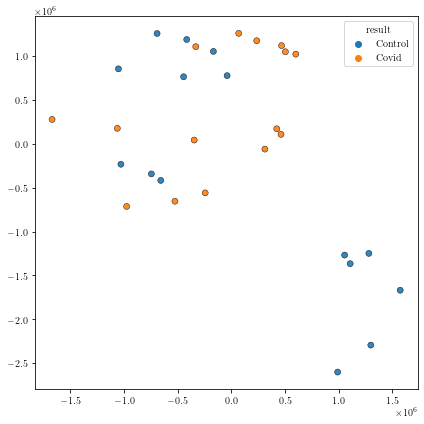

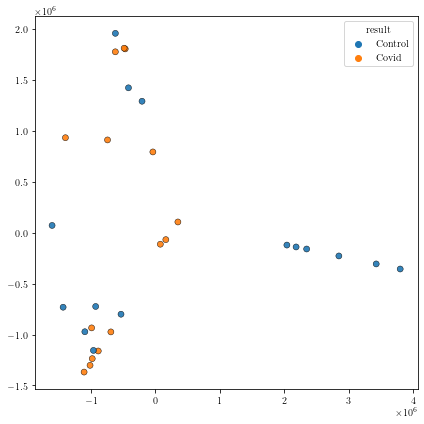

In [84]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
X_MDS = embedding.fit_transform(X)
principalDf = X_MDS
# 
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
ax = sns.scatterplot(x=principalDf[:,0], y=principalDf[:,1], hue=y, alpha=0.9, edgecolor='black')

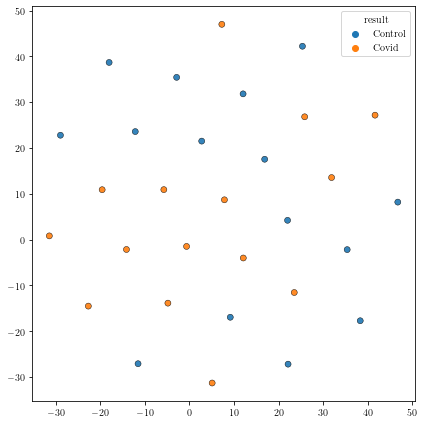

In [85]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2)
X_MDS = embedding.fit_transform(X)
principalDf = X_MDS
# 
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
ax = sns.scatterplot(x=principalDf[:,0], y=principalDf[:,1], hue=y, alpha=0.9, edgecolor='black')